In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D
import scipy.special as sp
from scipy.optimize import curve_fit

import pandas as pd

# To see the current working directory:
import os
os.path.abspath(os.getcwd())

'/Users/chnunez/Library/Mobile Documents/com~apple~CloudDocs/NiGroup/ObjectiveTests'

In [2]:
def normalize(img):
    return (img - np.min(img)) / (np.max(img) - np.min(img))

def splot(axis, data, col, xaxis=True):
    pixelnum = np.arange(0, len(data))
    pns = pixelnum # pixelnum no shift
    shift =  len(data)/2
    pixelnum = pixelnum-shift
    # Shift to actual length scale.
    pixelsize = 3.450 # um
    magnification = 1
    actual_length = pixelsize/magnification # in um
    larr = actual_length*pixelnum

    # Scatter
    axis.scatter(larr, data, s=30, facecolors='none', edgecolors=col, label="Non-normalized Data")

    ####################
    # Zemax Simulation #
    ####################
    # on-axis PSF.

    ###############
    # Theoretical #
    ###############
    # Fit center, offset, I0
    popt, pcov = curve_fit(gaussian, larr, data)
    # Plot fit
    xfit = np.linspace(larr[0], larr[-1], 2000)
    #axis.plot(xfit, gaussian(xfit, *popt), c=col, label="Fit: amp = {},\n waist = {}".format(str(round(popt[0],2)), str(round(popt[1], 2))))

    # Also plot the theoretical on-axis PSF
    #popt, pcov = curve_fit(PSF_center, larr, data)
    #axis.plot(xfit, PSF_center(xfit, popt[0]), c="gray", label="Theoretical On-Axis PSF", ls="--")

    axis.legend(fontsize=8, loc="upper left")

    return larr, data, pns


def plot_final(xc, yc, img, params):
    x1, length, y1, height = params[0], params[1], params[2], params[3]
    # Plot extraction
    fig,ax = plt.subplots(2, 2, figsize=(10,10))

    # Final extraction:
    norm = img[y1:y1+height, x1:x1+length]
    norm = normalize(norm)

    # Axis chooser: xc, yc
    plt.axvline(xc, c="red")     # x-axis
    plt.axhline(yc, c="green")   # y-axis 
    # Then create data:
    # note  the [:, 0] is there to select the first color channel
    # since it is grayscale, all color channels are the same. 
    ydata = norm[:, xc][:, 0]
    xdata = norm[yc, :][:, 0]

    ax[1,1].imshow(norm, cmap=plt.cm.gist_heat)
    ax[1,1].add_patch(patches.Rectangle((0, 0), length-1, height-1, linewidth=2, edgecolor="cyan", facecolor="none"))

    fig.tight_layout()
    splot(ax[0, 1], xdata, "green")
    splot(ax[1, 0], ydata, "red", False)
    ax[0,1].set_xlabel("x-position (nm)", fontsize=10)
    ax[1,0].set_xlabel("y-position (nm)", fontsize=10)
    ax[1,1].set_xlabel("x-pixel", fontsize=10)
    ax[1,1].set_ylabel("y-pixel", fontsize=10)
    
    fig.delaxes(ax=ax[0,0])

    fig.suptitle("Normalized Pixel Data and Theoretical PSF(NA = {}, $\lambda$ = {}nm)".format(str(NA), str(lam)), fontsize=16)
    plt.subplots_adjust(top=0.92)

    return ax, norm # Return first color channel of norm


def gaussian(x, a, w):
    return a*np.exp(-2*x**2/w**2)

def gaussian_sh(x, a, w, x0):
    return a*np.exp(-2*(x-x0)**2/w**2)


def plot_final_3d(xc, yc, img, params):
    x1, length, y1, height, box_size = params[0], params[1], params[2], params[3], params[4]
    # Plot extraction
    fig = plt.figure(figsize=(10,10))

    # Final extraction:
    norm = img[y1:y1+height, x1:x1+length]

    # Make subplots
    ax00 = fig.add_subplot(2,2,1, projection='3d')
    ax01 = fig.add_subplot(2,2,2)
    ax10 = fig.add_subplot(2,2,3)
    ax11 = fig.add_subplot(2,2,4)

    # Axis chooser: xc, yc
    ax11.axvline(xc, c="red")     # x-axis
    ax11.axhline(yc, c="green")   # y-axis 
    # Then create data:
    # note  the [:, 0] is there to select the first color channel
    # since it is grayscale, all color channels are the same. 
    ydata = norm[:, xc][:, 0]
    xdata = norm[yc, :][:, 0]

    ax11.imshow(norm, cmap=plt.cm.gist_heat)
    ax11.add_patch(patches.Rectangle((0, 0), length-1, height-1, linewidth=2, edgecolor="cyan", facecolor="none"))

    fig.tight_layout()
    larr, xdata, pixelnum = splot(ax01, xdata, "green")
    larr, ydata, pixelnum = splot(ax10, ydata, "red", False)
    ax01.set_xlabel("x-position (um)", fontsize=10)
    ax10.set_xlabel("y-position (um)", fontsize=10)
    ax11.set_xlabel("x-pixel", fontsize=10)
    ax11.set_ylabel("y-pixel", fontsize=10)
    
    # 3d part
    norm = norm[:, :, 0] # select first color channel
    xx, yy = np.mgrid[0:norm.shape[0], 0:norm.shape[1]]
    surf = ax00.plot_surface(xx, yy, norm, rstride=1, cstride=1,cmap=plt.cm.gray, linewidth=0)
    #plt.colorbar(surf, ax = ax00, shrink=0.5, aspect=20)
    ax00.plot([0, box_size], [0, 0], [0, 0], c="cyan", lw=2)
    ax00.plot([box_size, box_size], [0, box_size], [0, 0], c="cyan", lw=2)  
    ax00.plot([0, box_size], [box_size, box_size], [0, 0], c="cyan", lw=2)  
    ax00.plot([0, 0], [0, box_size], [0, 0], c="cyan", lw=2)  
    ax00.plot(xs=pixelnum, ys=xdata, zs=0, zdir='x',  c="green", label="x-axis cross-section")
    ax00.plot(xs=pixelnum, ys=ydata, zs=box_size, zdir='y',  c="red", label="y-axis cross-section")
    ax00.set_xlabel("y-position (pixel)", fontsize=10)
    ax00.set_ylabel("x-position (pixel)", fontsize=10)
    #ax00.plot([xc, xc], [0, box_size], [0.4, 0.4], c="red", lw=2)
    #ax00.plot([0, box_size], [yc, yc], [0.4, 0.4], c="green", lw=2)
    ax00.legend()

    #fig.suptitle("Normalized Pixel Data and Theoretical PSF(NA = {}, $\lambda$ = {}nm)".format(str(NA), str(lam)), fontsize=16)
    plt.subplots_adjust(top=0.92)

    return norm, xdata, ydata, pixelnum # Return first color channel of norm

# New function for 2D plotting:
# only works for square images
# note to convert between length_arr = larr to pixelnum:
# (M/pixsize)*larr + shift = pixnum
def splot2(axis, img, xaxis=True):
    data = img[:, 0] # to use len(data)
    pixelnum = np.arange(0, len(data))
    pns = pixelnum # pixelnum no shift
    shift =  len(data)/2
    pixelnum = pixelnum-shift
    # Shift to actual length scale.
    pixelsize = 3.450 # um
    magnification = 1
    actual_length = pixelsize/magnification # in um
    larr = actual_length*pixelnum


    xm, ym = np.meshgrid(larr, larr)

    #print(img.shape) --> don't forget img has 3 color chanels
    #print(img.ravel().shape)
    #print(xm.shape)

    # Also plot the theoretical on-axis PSF
    popt, pcov = curve_fit(gaussian2D, (xm, ym), img[:, :, 0].ravel())

  
    xfit = np.linspace(larr[0], larr[-1], 2000)
    axis.plot(xfit, gaussian_sh(xfit, popt[0], popt[1], popt[2]), label="x-axis fit, wx = "+str(np.round(popt[1], 2))+"um", ls="--", c="g")
    axis.plot(xfit, gaussian_sh(xfit, popt[0], popt[3], popt[4]), label="y-axis fit, wy = "+str(np.round(popt[3], 2))+"um", ls="--", c="r")

    return larr, popt, pcov, [magnification, pixelsize, shift]


# 2D shifted gausian with different waists
def gaussian2D(X, a, wx, x0, wy, y0):
    x, y = X
    g =  a*np.exp((-2 * ((x-x0)**2/wx**2)) + (-2 * ((y-y0)**2/wy**2)))
    return g.ravel()

def plot_final_array(img, params):
    x1, length, y1, height, box_size = params[0], params[1], params[2], params[3], params[4]
    # Plot extraction
    fig = plt.figure(figsize=(10,5))

    # Final extraction:
    norm = img[y1:y1+height, x1:x1+length]

    # Make subplots
    ax00 = fig.add_subplot(1,2,1)
    ax01 = fig.add_subplot(1,2,2)
    
    larr, popt, pcov, tra = splot2(ax00, norm)

    # Get the fitted center positions
    xc = popt[2]
    yc = popt[4]

    # Unpack transformation parameters
    M = tra[0]
    ps = tra[1]
    shift = tra[2]    

    # Convert back to camera coordinates
    xc = (M/ps)*xc + shift
    yc = (M/ps)*yc + shift

    # Convert center positions to pixels via rounding
    xc = int(np.round(xc))
    yc = int(np.round(yc))

    #print(xc, yc)
    norm = norm[:, :, 0] # select only one color channel
    xdata = norm[yc, :]
    ydata = norm[:, xc]
    
    ax00.scatter(larr, xdata, c = "g", s=5)
    ax00.scatter(larr, ydata, c = "r", s=5)

    #ax01.legend()
    ax00.legend()

    # Show image
    ax01.imshow(norm)
    ax01.axvline(xc, c="red")     # x-axis
    ax01.axhline(yc, c="green")   # y-axis

    fig.tight_layout()

    plt.subplots_adjust(top=0.92)

    return norm, larr, popt, pcov # Return first color channel of norm

In [ ]:
# Loop the frames and choose xc and yc
extension = "../NaSLM/June28Painting/"
filenames = ["70MHz.png", "75MHz.png", "80MHz.png", "85MHz.png", "90MHz.png"]
xc_arr = [30,30,30,30,30]
yc_arr = [33,33,31,31,31]
hori_arrays = []
data_arrays = []

for num in range(len(filenames)):
    # STEP 0: Upload image.
    photo = extension + filenames[num]
    img = plt.imread(photo)

    fig0,ax0 = plt.subplots(1, 2, figsize=(16,6))
    ax0[0].imshow(img)
    ax0[0].set_title("Original Image")

    # STEP 1: Crop image.
    cropx, x_len, cropy, y_len = 400, 200, 200, 200
    img = plt.imread(photo)
    img = img[cropy:cropy+y_len, cropx:cropx+x_len]

    # STEP 2: Select bounding box.
    box_size = 60
    x1, length, y1, height = 55, box_size, 108, box_size
    params = [x1, length, y1, height, box_size]
    rect1 = patches.Rectangle((x1, y1), length, height, linewidth=1, edgecolor="cyan", facecolor="none")
    ax0[1].add_patch(rect1)
    ax0[1].text(x1, y1-2,'Sample', c="cyan")

    # Display cropped image
    ax0[1].imshow(img)
    ax0[1].set_title("(Non-normalized) Cropped Image")

    # Also add the rectangle to the other image
    rect_corrected = patches.Rectangle((x1+cropx, y1+cropy), length, height, linewidth=1, edgecolor="cyan", facecolor="none")
    ax0[0].add_patch(rect_corrected)

    # STEP 3: Choose axes and plot result:
    xc = xc_arr[num]
    yc = yc_arr[num]
    fp_img = plt.imread(photo) # final plot image
    fp_img = fp_img[cropy:cropy+y_len, cropx:cropx+x_len]
    norm, xdata, ydata, pixelnum = plot_final_3d(xc, yc, fp_img, params)
    hori_arrays.append(pixelnum)
    data_arrays.append(xdata)


In [ ]:
fig, ax = plt.subplots()
for i in range(len(data_arrays)):
    plt.plot(hori_arrays[i], data_arrays[i])

plt.plot(hori_arrays[0], np.sum(data_arrays, axis=0))



In [ ]:
# Loop the frames and choose xc and yc
extension = "../NaSLM/June28Painting/"
filenames = ["7090paint.png"]
xc_arr = [30]
yc_arr = [30]
hori_arrays = []
data_arrays = []

for num in range(len(filenames)):
    # STEP 0: Upload image.
    photo = extension + filenames[num]
    img = plt.imread(photo)

    fig0,ax0 = plt.subplots(1, 2, figsize=(16,6))
    ax0[0].imshow(img)
    ax0[0].set_title("Original Image")

    # STEP 1: Crop image.
    cropx, x_len, cropy, y_len = 400, 180, 200, 180
    img = plt.imread(photo)
    img = img[cropy:cropy+y_len, cropx:cropx+x_len]

    # STEP 2: Select bounding box.
    box_size = 60
    x1, length, y1, height = 65, box_size, 73, box_size
    params = [x1, length, y1, height, box_size]
    rect1 = patches.Rectangle((x1, y1), length, height, linewidth=1, edgecolor="cyan", facecolor="none")
    ax0[1].add_patch(rect1)
    ax0[1].text(x1, y1-2,'Sample', c="cyan")

    # Display cropped image
    ax0[1].imshow(img)
    ax0[1].set_title("(Non-normalized) Cropped Image")

    # Also add the rectangle to the other image
    rect_corrected = patches.Rectangle((x1+cropx, y1+cropy), length, height, linewidth=1, edgecolor="cyan", facecolor="none")
    ax0[0].add_patch(rect_corrected)

    # STEP 3: Choose axes and plot result:
    xc = xc_arr[num]
    yc = yc_arr[num]
    fp_img = plt.imread(photo) # final plot image
    fp_img = fp_img[cropy:cropy+y_len, cropx:cropx+x_len]
    norm, xdata, ydata, pixelnum = plot_final_3d(xc, yc, fp_img, params)
    hori_arrays.append(pixelnum)
    data_arrays.append(xdata)


Text(0.5, 1.0, 'mean = 1.0, median = 1.0, std dev = 0.02')

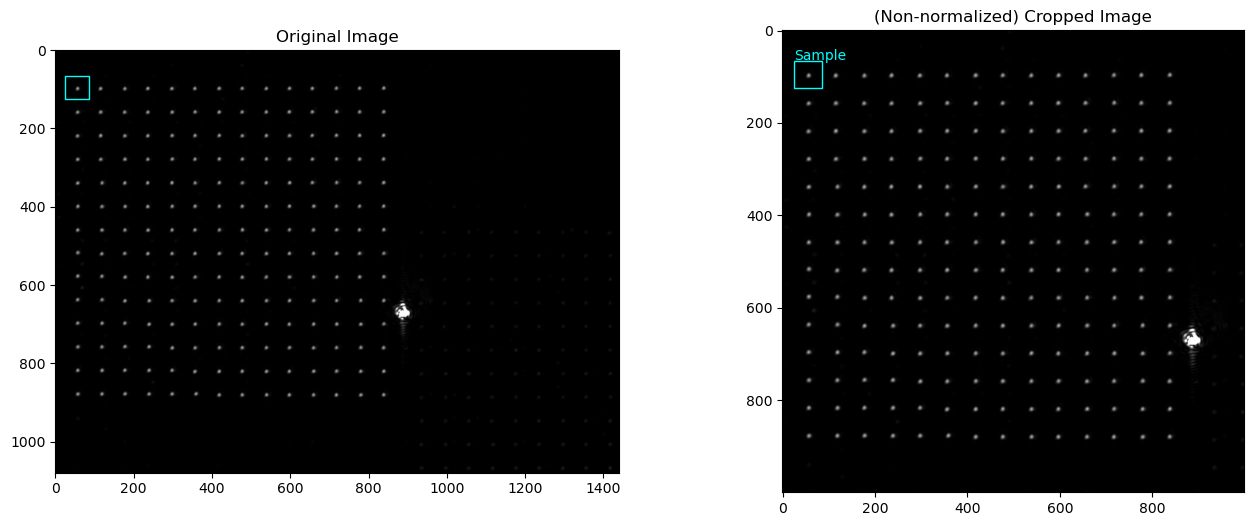

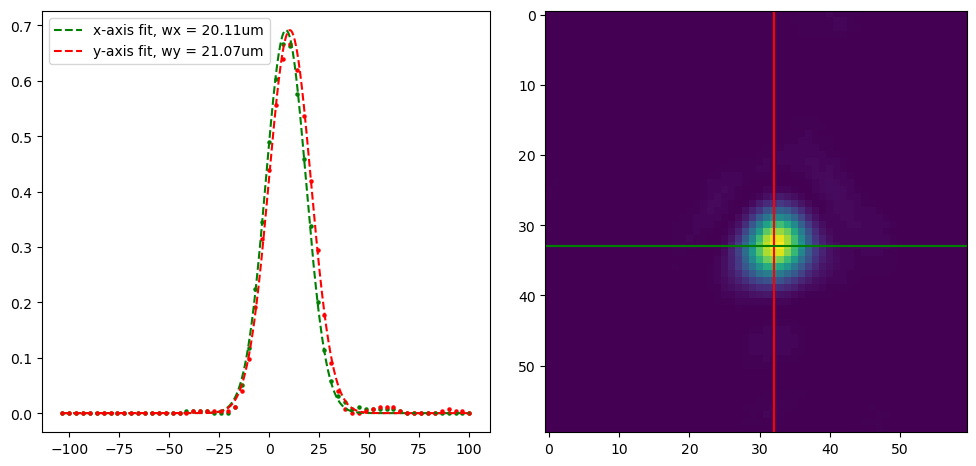

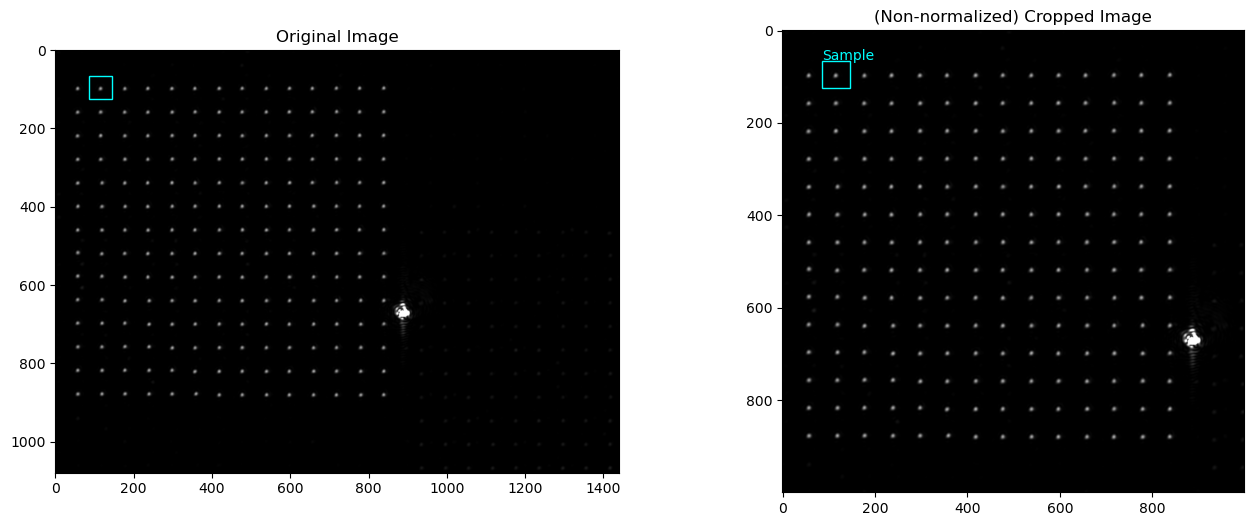

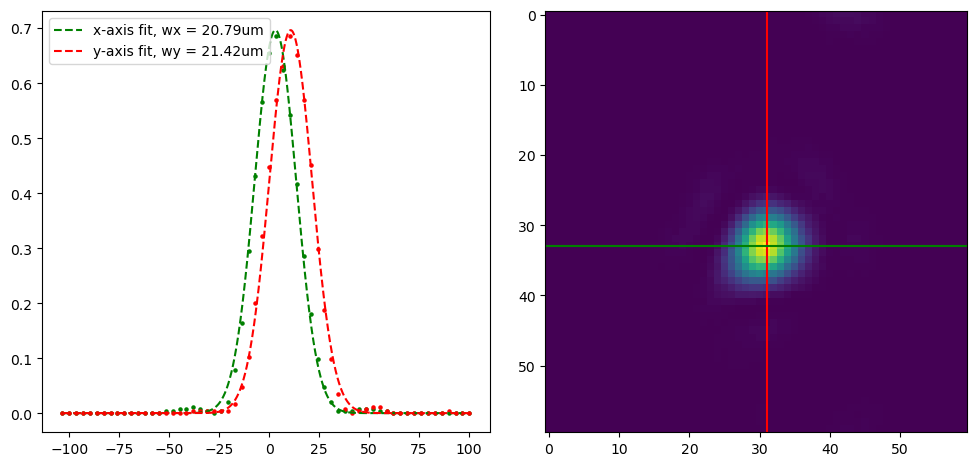

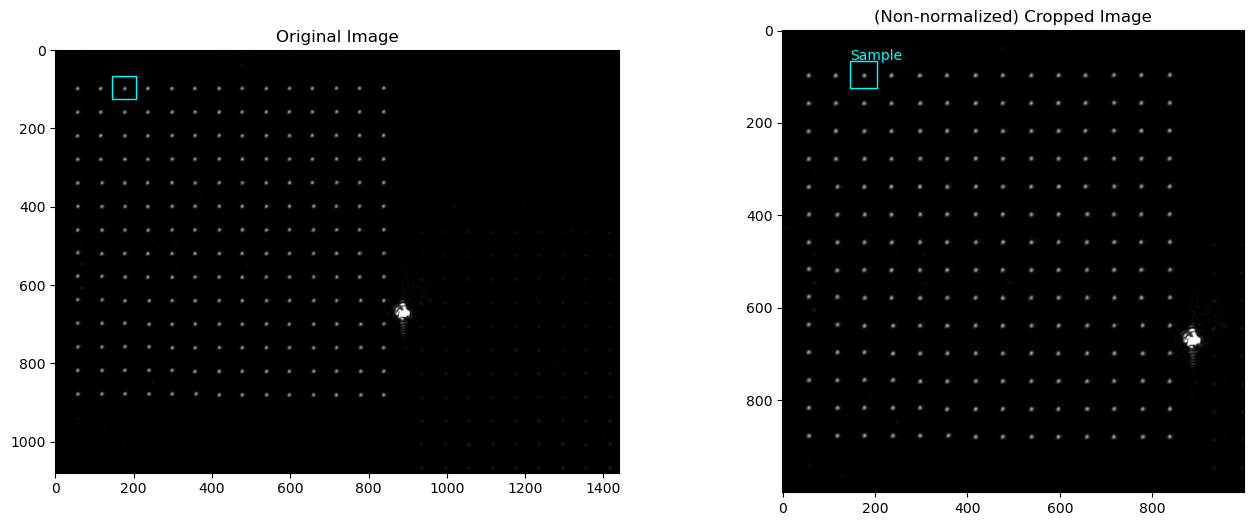

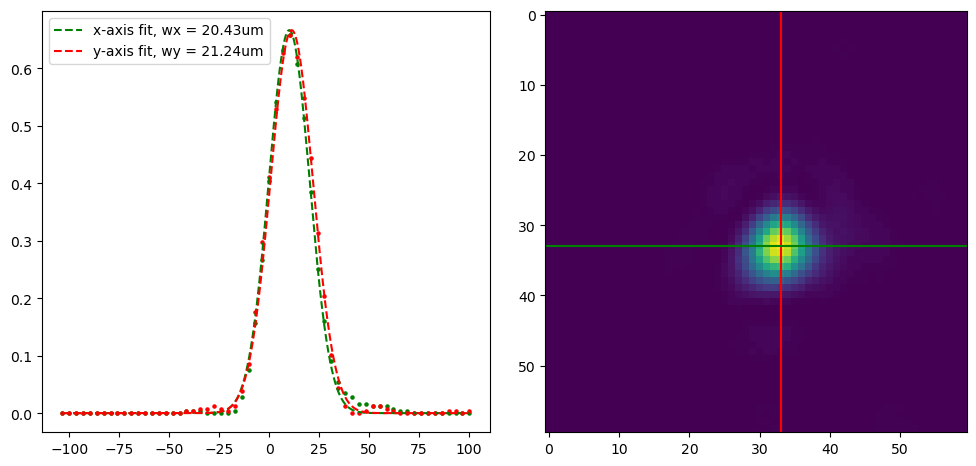

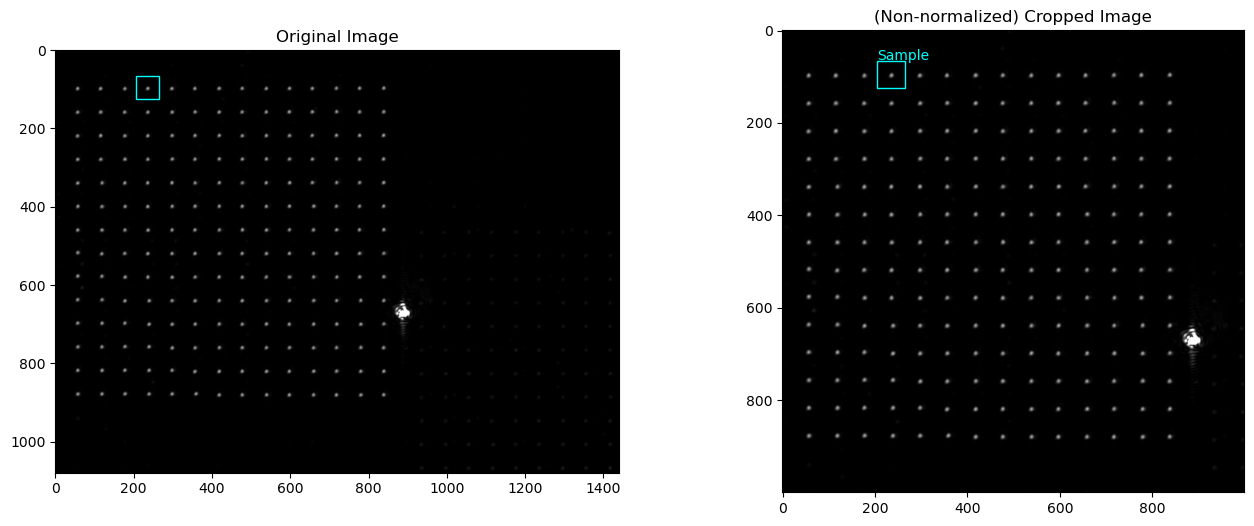

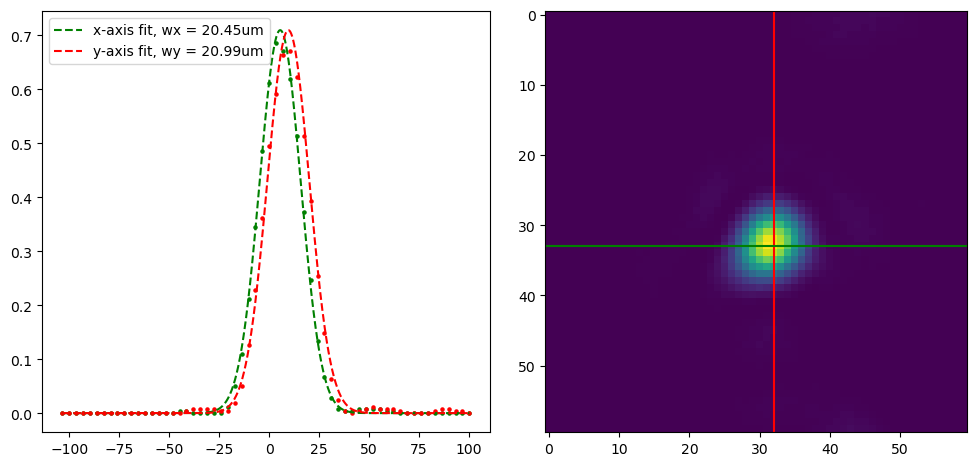

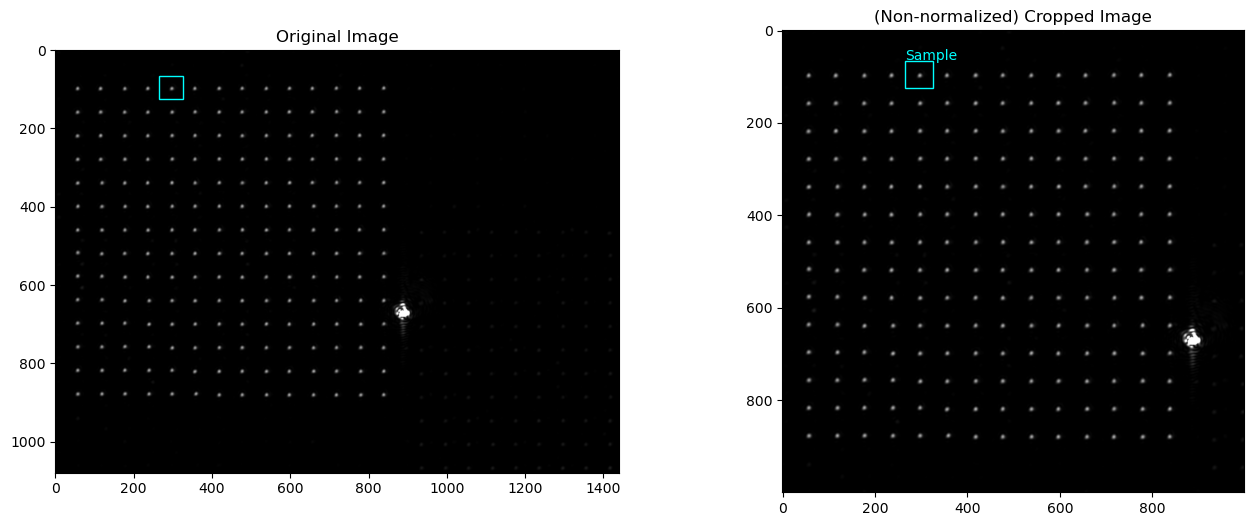

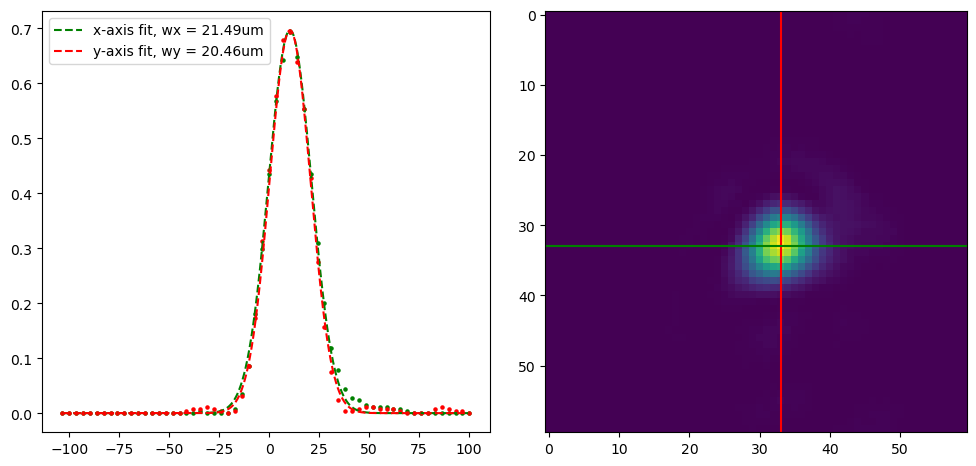

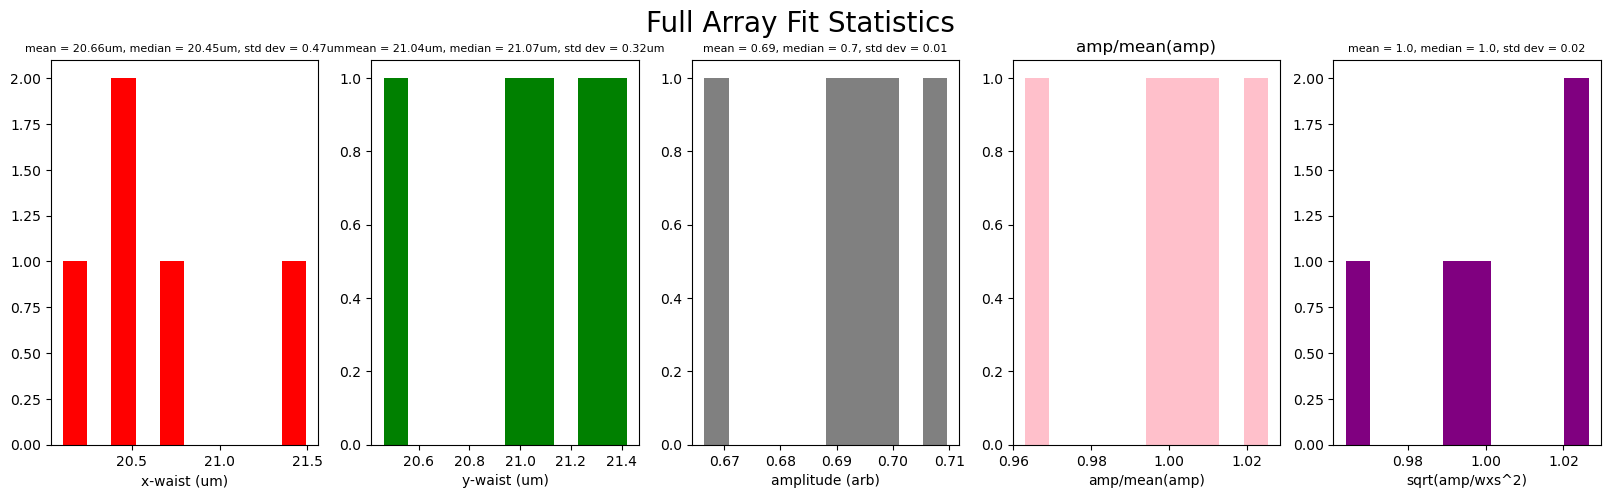

In [3]:
# Testing the 2D fitter:
extension = "../NaSLM/June28Painting/"
filenames = ["f400_feedback4.png"]
hori_arrays = []
data_arrays = []
popt_arrays = []
pcov_arrays = []

x_step = 60
y_step = 60

for num in range(len(filenames)):
    for xi in range(0, 5):
        for yi in range(0, 1):
            if yi == 6 and xi == 0:
                continue 

            if yi == 13 and xi ==0:
                continue

            # STEP 0: Upload image.
            photo = extension + filenames[num]
            img = plt.imread(photo)

            fig0,ax0 = plt.subplots(1, 2, figsize=(16,6))
            ax0[0].imshow(img)
            ax0[0].set_title("Original Image")

            # STEP 1: Crop image.
            cropx, x_len, cropy, y_len = 0, 1000, 0, 1000
            img = plt.imread(photo)
            img = img[cropy:cropy+y_len, cropx:cropx+x_len]

            # STEP 2: Select bounding box.
            box_size = 60
            x1, length, y1, height = 25+(xi*x_step), box_size, 65+(yi*y_step), box_size
            params = [x1, length, y1, height, box_size]
            rect1 = patches.Rectangle((x1, y1), length, height, linewidth=1, edgecolor="cyan", facecolor="none")
            ax0[1].add_patch(rect1)
            ax0[1].text(x1, y1-2,'Sample', c="cyan")

            # Display cropped image
            ax0[1].imshow(img)
            ax0[1].set_title("(Non-normalized) Cropped Image")

            # Also add the rectangle to the other image
            rect_corrected = patches.Rectangle((x1+cropx, y1+cropy), length, height, linewidth=1, edgecolor="cyan", facecolor="none")
            ax0[0].add_patch(rect_corrected)

            # STEP 3: Choose axes and plot result:
            fp_img = plt.imread(photo) # final plot image
            fp_img = fp_img[cropy:cropy+y_len, cropx:cropx+x_len]
            norm, larr, popt, pcov = plot_final_array(fp_img, params)
            popt_arrays.append(popt)
            pcov_arrays.append(pcov)

# Histograms
hfig, hax = plt.subplots(1, 5, figsize=(20,5))

plt.suptitle("Full Array Fit Statistics", fontsize=20)

#Extract all waists
wxs = []
wys = []
a_arr = []
for popt in popt_arrays:
    a_arr.append(popt[0])
    wxs.append(popt[1])
    wys.append(popt[3])

wxs = np.array(wxs)
wys = np.array(wys)
a_arr = np.array(a_arr)

hax[0].hist(wxs, color= "r", label="x-waist")
hax[0].set_xlabel("x-waist (um)")
hax[0].set_title("mean = {}um, median = {}um, std dev = {}um".format(round(np.mean(wxs),2), round(np.median(wxs),2), round(np.std(wxs),2)), fontsize=8)

hax[1].hist(wys, color="g", label="y-waist")
hax[1].set_xlabel("y-waist (um)")
hax[1].set_title("mean = {}um, median = {}um, std dev = {}um".format(round(np.mean(wys),2), round(np.median(wys),2), round(np.std(wys),2)), fontsize=8)

hax[2].hist(a_arr, color="gray", label="amplitude")
hax[2].set_xlabel("amplitude (arb)")
hax[2].set_title("mean = {}, median = {}, std dev = {}".format(round(np.mean(a_arr),2), round(np.median(a_arr),2), round(np.std(a_arr),2)), fontsize=8)

hax[3].hist(a_arr/np.mean(a_arr), color="pink")
hax[3].set_xlabel("amp/mean(amp)")
hax[3].set_title("amp/mean(amp)")

p4 = np.sqrt(a_arr/wxs**2)
p4 = p4/np.mean(p4)
hax[4].hist(p4, color="purple")
hax[4].set_xlabel("sqrt(amp/wxs^2)")
hax[4].set_title("mean = {}, median = {}, std dev = {}".format(round(np.mean(p4),2), round(np.median(p4),2), round(np.std(p4),2)), fontsize=8)